Суть этого скрипта в **анализе протокола** и **записи данных в "Generating droplets_database"**. Формат может быть как .csv, так и .xlsx

TODO:
 - Не забыть добавить переименовывание теста и видеофайла!

In [1]:
# ИМПОРТ БИБЛИОТЕК И НАСТРОЙКА ВЫВОДА
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import seaborn as sns

import win32con, win32api, os

import warnings; warnings.simplefilter('ignore')
sns.set()

In [2]:
# ФАЙЛОВЫЕ ПЕРЕМЕННЫЕ:
# путь к корневой папке данных
main_path = 'Z:\\Projects\\РФФИ-Норвегия\\Данные\\Экспериментальные данные в лаборатории\\Droplet freezing facility data\\Generating droplets'
# имя обрабатываемого протокола
prot_name = '2021-02-09--2021-03-10_Протокол генерации капель_запись возле форсунки.xlsx'
# имя папки, содержащей видео
video_folder = 'VIDEO_DATA'

In [3]:
# ИМПОРТ И ПОДГОТОВКА ДАТАФРЕЙМОВ
# чтение Excel-файла в protocol_dataframe
prot_df = pd.read_excel(os.path.join(main_path, prot_name))
# чтение дополнительных данных из Excel-файла в adititional_dataframe
adit_df = pd.read_excel(os.path.join(main_path, prot_name), sheet_name=1)

# Поменяем заголовки столбцов для удобства работы с ними
prot_df.columns = ['test', 'test_type', 'voltage', 'pressure',
       'impulse_time', 'needle', 'nozzle', 'distance',
       'calibrat_test', 'record_rate', 'comments', 'experiment_date',
       'tester']
adit_df.columns = ['param_name', 'param_value', 'tester', 'tester_mail',
       'test_type ', 'test_descr', 'needle_type', 'needle_descr',
       'nozzle_num', 'nozzle_descr']

# вывод информации по колонкам
print(prot_df.info())
print(adit_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   test             242 non-null    int64         
 1   test_type        242 non-null    object        
 2   voltage          234 non-null    float64       
 3   pressure         234 non-null    float64       
 4   impulse_time     234 non-null    float64       
 5   needle           234 non-null    object        
 6   nozzle           234 non-null    object        
 7   distance         0 non-null      float64       
 8   calibrat_test    234 non-null    float64       
 9   record_rate      234 non-null    float64       
 10  comments         40 non-null     object        
 11  experiment_date  242 non-null    datetime64[ns]
 12  tester           242 non-null    object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 24.7+ KB
None
<class 'panda

In [4]:
# ОПРЕДЕЛЕНИЕ НАЛИЧИЯ ВИДЕО
# составляем список содержимого в папке с видео 
video_folder_list = os.listdir(os.path.join(main_path, video_folder))
# Cоставим словарь видеофайлов в формате {№ теста: [список расширений]}
video_dict = {}
for elem in video_folder_list:
    # определяем расширение файла
    file_extenstion = elem.split('.')[1]
    # если это не видеофайл - пропускаем
    if not(elem.split('.')[1] in ['avi','mraw']):
        continue
    # Оставляем от имени файла только номер теста
    file_name = elem.split('.')[0]
    test_num = int(file_name.split('_')[0])
    # TODO: ввести проверку на соответствие номера типу /d/d/d/d
    
    # Добавляем этот файл в словарь
    if not(test_num in video_dict):
        video_dict[test_num] = [file_extenstion]
    else:
        video_dict[test_num].append(file_extenstion)
        video_dict[test_num].sort()

# Функция определения наличия видео:
def video_finder(test_num):
    if not(test_num in video_dict):
        res = 'no'
    else:
        res = ', '.join(video_dict[test_num])
    return res

# Составим колонку video, содержащую данные по наличию видео теста
prot_df['video'] = prot_df['test'].apply(lambda x: video_finder(x))
# Выведем данные
print('Количество тестов в датафрейме:', prot_df['test'].count())
print('Количество тестов по видео:', len(video_dict))
print('Распределение тестов по наличию видео:')
print(prot_df['video'].value_counts())
print('\nТесты, у которых отсутствует видео:')
print(list(prot_df[prot_df['video'] == 'no']['test'].values))

# Сохраним отдельно набор тестов без видео
without_video = prot_df[prot_df['video'] == 'no_video'].copy()
without_video.reset_index(inplace=True)
without_video.drop('index', axis=1, inplace=True)
#without_video.to_excel(os.path.join(main_path,'_temp_folder','no_video.xlsx'), index=False)

# Тесты только с mraw:
print('Тесты только c mraw:', list(prot_df[prot_df['video'] == 'mraw']['test'].values))

# Тесты только с avi:
print('Тесты только c avi:')
print(list(prot_df[prot_df['video'] == 'avi']['test'].values))

Количество тестов в датафрейме: 242
Количество тестов по видео: 232
Распределение тестов по наличию видео:
avi, mraw    194
avi           37
no            10
mraw           1
Name: video, dtype: int64

Тесты, у которых отсутствует видео:
[51, 55, 57, 81, 216, 228, 240, 251, 264, 273]
Тесты только c mraw: [278]
Тесты только c avi:
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 56, 58, 59, 63, 76, 128, 142, 178, 214, 226, 249]


In [5]:
# ОБРАБОТКА .CSV АННЫ И ДОБАВЛЕНИЕ ДАННЫХ В ОБЩИЙ DF
csv_df = pd.read_csv(os.path.join(main_path, '_archive\\Карты режимов.csv'))
csv_df.drop(['Unnamed: 0', 'Unnamed: 4', 'Экспозиция'], axis=1, inplace=True)
csv_df.columns = ['test', 'nozzle', 'needle', 'voltage', 'pressure',
       'impulse_time', 'record_rate', 'calibrat_test', 
       'pixel_size', 'flow_type',
       'droplet_size', 'starting_velocity', 'comments']
# Проверка по ключевым показателям показала идентичность записей протокола и df Анны
#csv_df['voltage'] = csv_df['voltage'].str.replace(',','.')
#csv_df['voltage'] = csv_df['voltage'].apply(float)
#csv_df['pressure'] = csv_df['pressure'].str.replace(',','.')
#csv_df['pressure'] = 1000*csv_df['pressure'].apply(float)

prot_df = prot_df.merge(csv_df[['test', 'pixel_size', 'flow_type', 'droplet_size', 'starting_velocity']], how='right', on='test')
prot_df['ending_velocity'] = None

prot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242 entries, 0 to 241
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   test               242 non-null    int64         
 1   test_type          242 non-null    object        
 2   voltage            234 non-null    float64       
 3   pressure           234 non-null    float64       
 4   impulse_time       234 non-null    float64       
 5   needle             234 non-null    object        
 6   nozzle             234 non-null    object        
 7   distance           0 non-null      float64       
 8   calibrat_test      234 non-null    float64       
 9   record_rate        234 non-null    float64       
 10  comments           40 non-null     object        
 11  experiment_date    242 non-null    datetime64[ns]
 12  tester             242 non-null    object        
 13  video              242 non-null    object        
 14  pixel_size

In [6]:
# ОБРАБОТКА ОБЪЕДИНЁННОГО DF
# Превратим 'pixel_size' в float
prot_df['pixel_size'] = prot_df['pixel_size'].str.replace(',','.')
prot_df['pixel_size'].astype(float)
prot_df['pixel_size'] = prot_df['pixel_size'].apply(pd.to_numeric, errors='ignore')

# Заменим значения flow_type и выведем распределение по ним:
def replace_flow_type(x):
    if x['test_type'] == 'calibrat':
        x['flow_type'] = 'no'
    elif x['flow_type'] == 'Струя, разделяющаяся на капли':
        x['flow_type'] = 'splitting_jet'
    elif x['flow_type'] == 'Одиночная капля':
        x['flow_type'] = 'single'
    elif x['flow_type'] == 'Серия капель':
        x['flow_type'] = 'set'
    elif x['flow_type'] == 'Нет капель':
        x['flow_type'] = 'no'
    elif x['flow_type'] == 'Сплошная струя':
        x['flow_type'] = 'continuous_jet'   
    return x

prot_df['flow_type'] = prot_df.apply(replace_flow_type, axis=1)['flow_type']

print('Типы потока из сопла (без дозаполнения):')
print(prot_df['flow_type'].value_counts(dropna=False))

# Посмотрим, какой тип потока у тестов без видео
print('\nРаспределение тестов без видео по типу потока:')
prot_df[prot_df['video'] == 'no']['flow_type'].value_counts(dropna=False)

Типы потока из сопла (без дозаполнения):
splitting_jet     83
single            57
set               40
no                30
NaN               28
continuous_jet     4
Name: flow_type, dtype: int64

Распределение тестов без видео по типу потока:


no     6
NaN    3
set    1
Name: flow_type, dtype: int64

In [7]:
# ЗАПОЛНЕНИЕ ПОТОКОВ ВРУЧНУЮ
print('Номера тестов, в которых не указан тип потока: ')
print(list(prot_df[prot_df['flow_type'].isna()]['test']))

# Проанализируем вручную и запишем результат
dict_find_flow = dict.fromkeys(list(prot_df[prot_df['flow_type'].isna()]['test']))
dict_find_flow[29] = 'single'
dict_find_flow[30] = 'single'
dict_find_flow[31] = 'single'
dict_find_flow[33] = 'single'
dict_find_flow[34] = 'set'
dict_find_flow[36] = 'set'
dict_find_flow[37] = 'single'
dict_find_flow[38] = 'single'
dict_find_flow[39] = 'set'
dict_find_flow[40] = 'single'
dict_find_flow[41] = 'set'
dict_find_flow[42] = 'splitting_jet'
dict_find_flow[44] = 'single'
dict_find_flow[45] = 'single'
dict_find_flow[46] = 'single'
dict_find_flow[47] = 'single'
dict_find_flow[48] = 'set'
dict_find_flow[49] = 'single'
dict_find_flow[50] = 'splitting_jet'
dict_find_flow[51] = 'nan' # видео отсутствует
dict_find_flow[52] = 'single'
dict_find_flow[53] = 'single'
dict_find_flow[54] = 'set'
dict_find_flow[55] = 'nan' # видео отсутствует
dict_find_flow[56] = 'single'
dict_find_flow[57] = 'nan' # видео отсутствует
dict_find_flow[58] = 'set'
dict_find_flow[59] = 'splitting_jet'

print('Заполнено Вульф Михаилом:', len(list(prot_df[prot_df['flow_type'].isna()]['test']))-3)
print(dict_find_flow)

# Заполним dataframe по потокам
def flow_type_fill(x):
    if pd.isna(x['flow_type']):
        x['flow_type'] = dict_find_flow[x['test']]
    return x

prot_df['flow_type'] = prot_df.apply(flow_type_fill, axis=1)['flow_type']

print('\nТипы потока из сопла:')
print(prot_df['flow_type'].value_counts())

Номера тестов, в которых не указан тип потока: 
[29, 30, 31, 33, 34, 36, 37, 38, 39, 58, 40, 41, 42, 57, 45, 46, 47, 48, 49, 50, 51, 52, 53, 59, 44, 56, 54, 55]
Заполнено Вульф Михаилом: 25
{29: 'single', 30: 'single', 31: 'single', 33: 'single', 34: 'set', 36: 'set', 37: 'single', 38: 'single', 39: 'set', 58: 'set', 40: 'single', 41: 'set', 42: 'splitting_jet', 57: 'nan', 45: 'single', 46: 'single', 47: 'single', 48: 'set', 49: 'single', 50: 'splitting_jet', 51: 'nan', 52: 'single', 53: 'single', 59: 'splitting_jet', 44: 'single', 56: 'single', 54: 'set', 55: 'nan'}

Типы потока из сопла:
splitting_jet     86
single            72
set               47
no                30
continuous_jet     4
nan                3
Name: flow_type, dtype: int64


In [8]:
# АНАЛИЗ ОБРАБОТАННЫХ ДАННЫХ
# Определим, какие типы потока были проанализированы
print('\nТипы потока, которые были проанализированы по размеру капель:')
print(prot_df[prot_df['droplet_size'].notna()]['flow_type'].value_counts())
analyzed = prot_df[prot_df['droplet_size'].notna()]['test'].count()
single_tests = prot_df[prot_df['flow_type'] == 'single']['test'].count()
print('Общее число тестов с одиночными каплями: ', single_tests)

# Определим, какие видеофайлы у обрабатываемых Анной строк
print('\nФорматы видео тестов с обработанными размерами капель:')
print(prot_df[prot_df['droplet_size'].notna()]['video'].value_counts())



Типы потока, которые были проанализированы по размеру капель:
single    49
Name: flow_type, dtype: int64
Общее число тестов с одиночными каплями:  72

Форматы видео тестов с обработанными размерами капель:
avi, mraw    47
avi           2
Name: video, dtype: int64


## Определение имеющихся параметрических точек
Значимые параметры содержатся в следующих колонках:
- **voltage**
- **pressure**
- impulse_time
- *needle*

Распределение тестов по иглам:
N01-1    213
N02-1     10
N04-1      7
N03-1      3
N05-1      1
Name: needle, dtype: int64
Остановимся на самом частом типе иглы: N01-1

Рассмотрим распределение по времени импульса, мкс:
5000.0    149
4000.0     64
Name: impulse_time, dtype: int64

Для каждого значения определим набор точек давление/напряжение


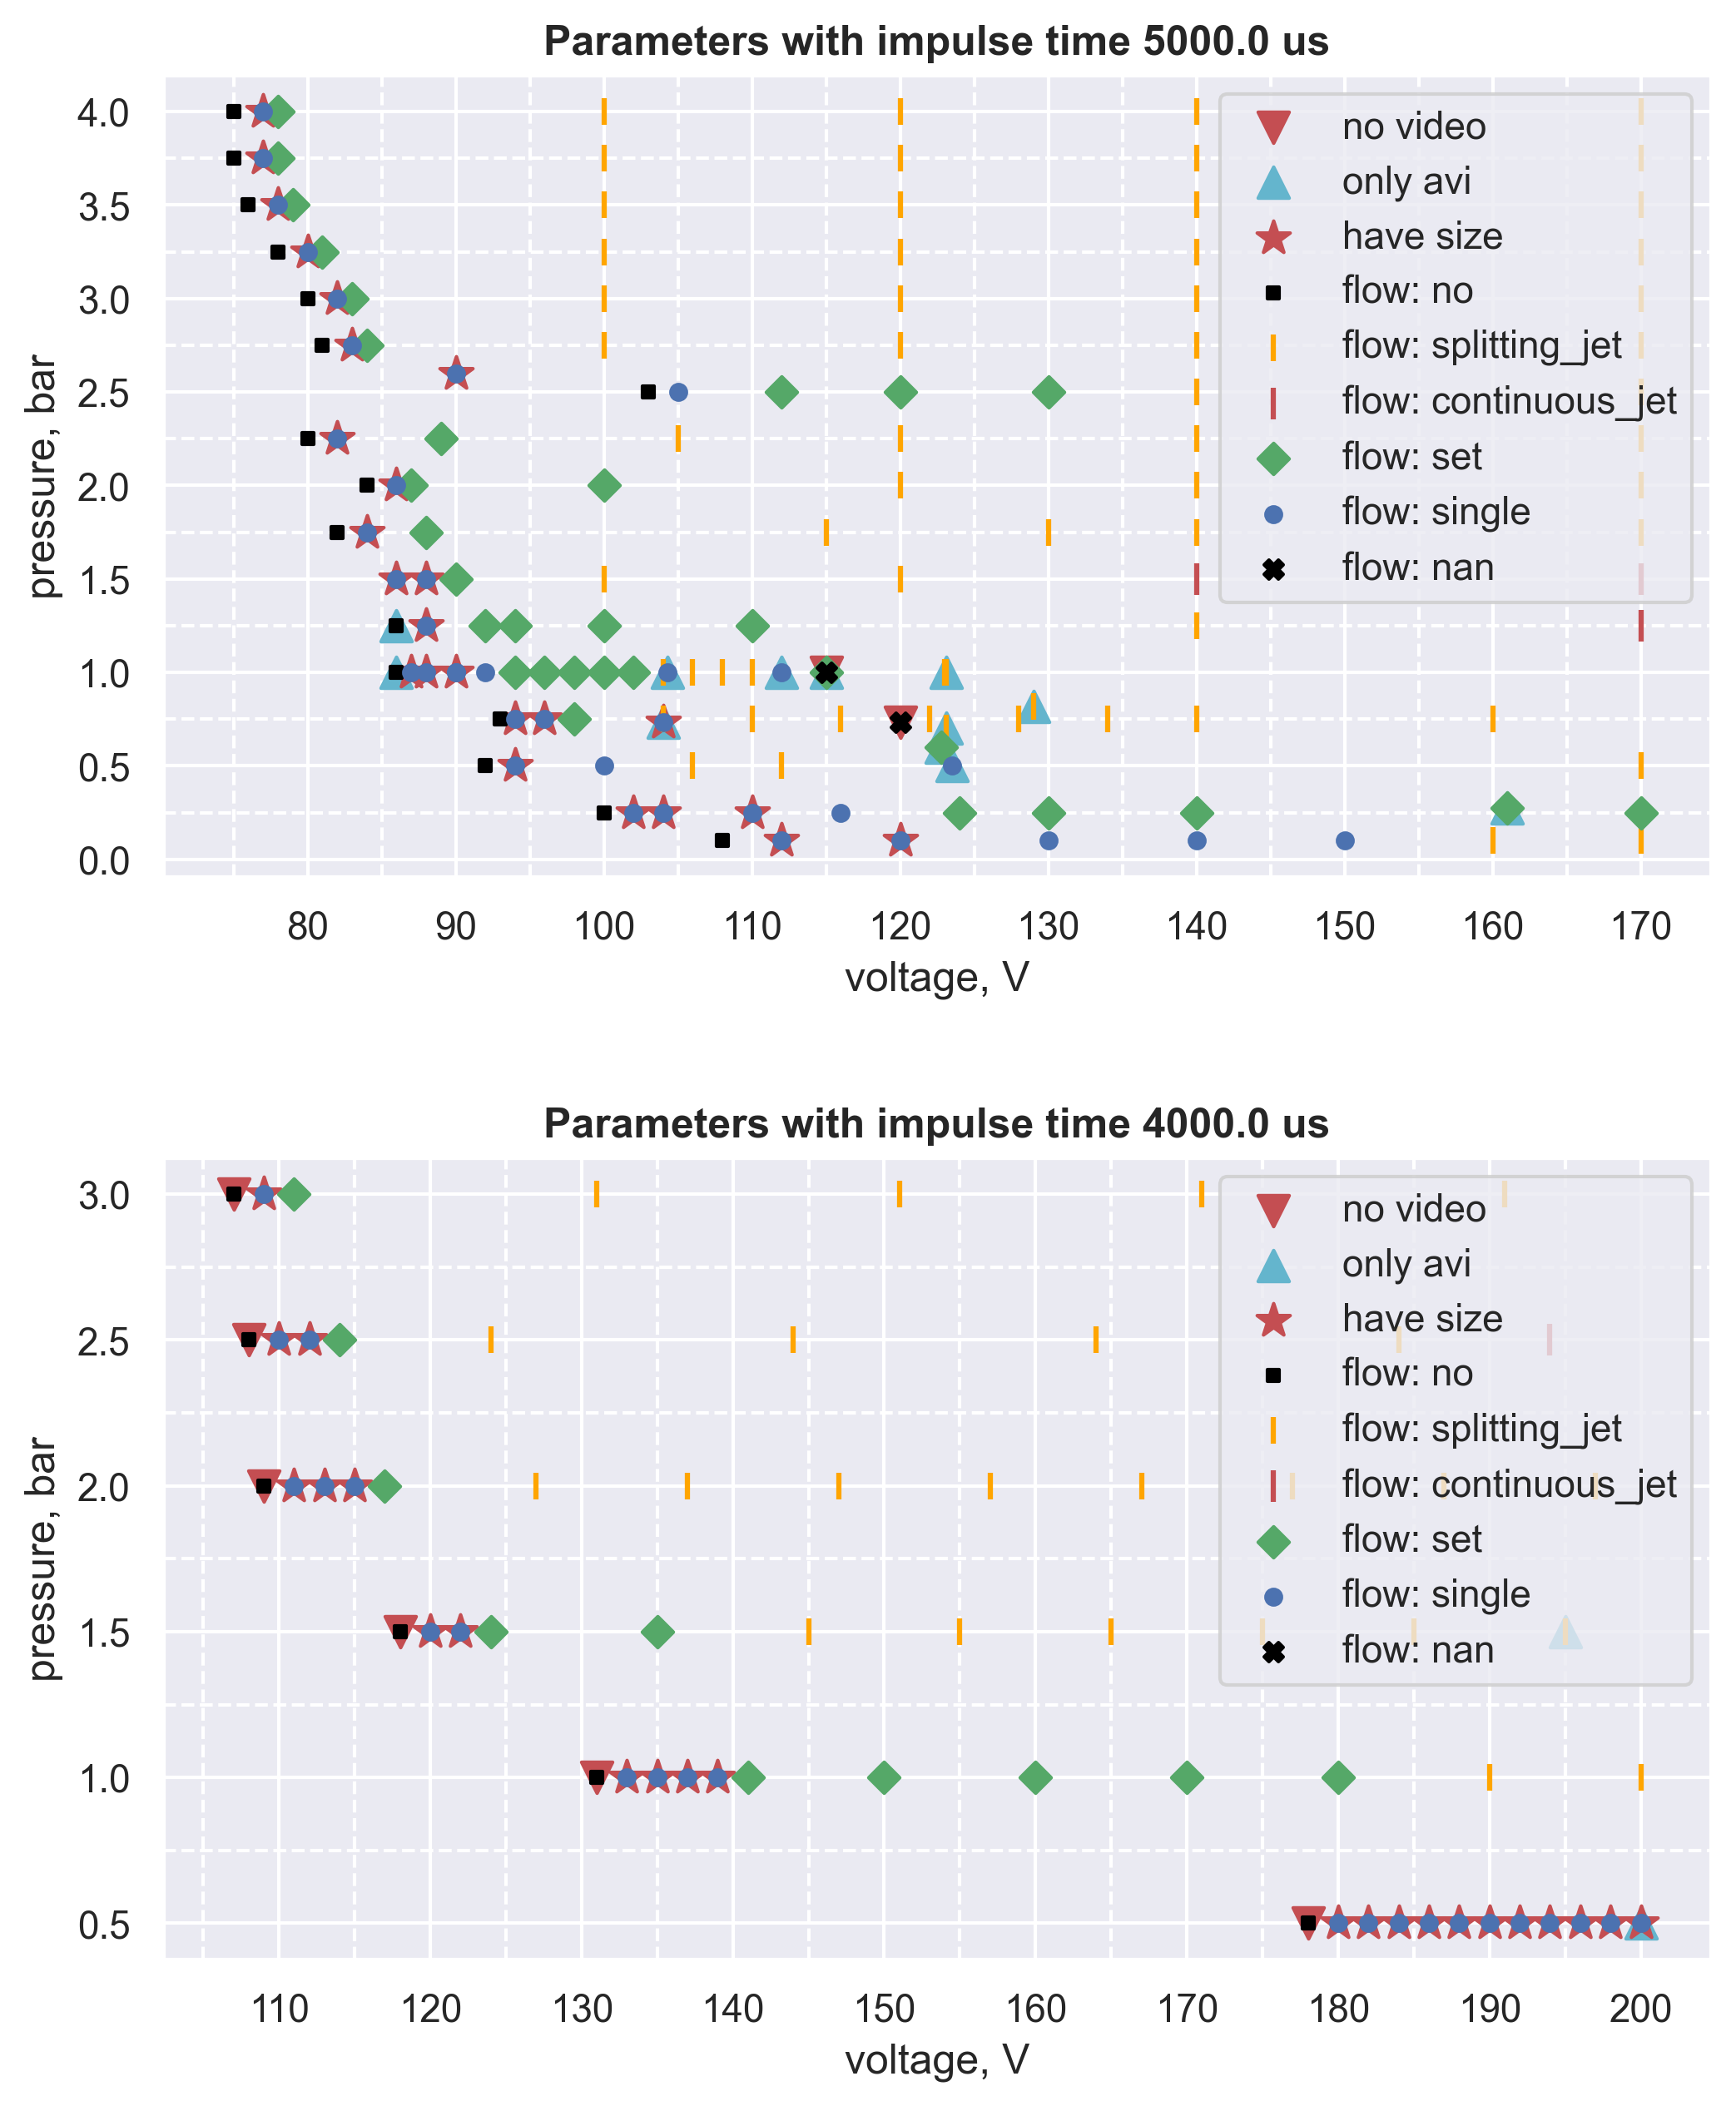

In [9]:
# АНАЛИЗ ИМЕЮЩИХСЯ ПАРАМЕТРИЧЕСКИХ ТОЧЕК
print('Распределение тестов по иглам:')
print(prot_df['needle'].value_counts())
print('Остановимся на самом частом типе иглы:', prot_df['needle'].value_counts().index[0])
# Далее работаем с частью датафрейма:
one_needle_df = prot_df[prot_df['needle']=='N01-1']

print('\nРассмотрим распределение по времени импульса, мкс:')
print(one_needle_df['impulse_time'].value_counts())
print('\nДля каждого значения определим набор точек давление/напряжение')
# Разделим данные по времени импульса
impulse_time_list = list(one_needle_df['impulse_time'].value_counts().index)

# ПОСТРОИМ ГРАФИКИ ПАРАМЕТРОВ
fig, axes = plt.subplots(len(impulse_time_list), 1, figsize=(8,10), dpi=300)
plt.subplots_adjust(wspace=0.35, hspace=0.35)
for i, impulse_time in enumerate(impulse_time_list):
    # Записываем датафрейм с одним значением времени импульса
    one_time_df = one_needle_df[one_needle_df['impulse_time']==impulse_time]
    # Подготавливаем поле для построения
    axes[i].set_title('Parameters with impulse time {} us'.format(impulse_time), fontweight="bold")
    axes[i].set_xlabel('voltage, V')
    axes[i].set_ylabel('pressure, bar')

    # Настраиваем число разделений по осям
    axes[i].yaxis.set_major_locator(MultipleLocator(0.5))
    axes[i].yaxis.set_minor_locator(MultipleLocator(0.25))

    axes[i].xaxis.set_major_locator(MultipleLocator(10))
    axes[i].xaxis.set_minor_locator(MultipleLocator(5))

    axes[i].grid(which='minor', linestyle='--')
    
    # Составим словарь: тип потока : [размер, тип маркера, цвет маркера
    default_size = 10
    flow_type_dict = {
        'nan' : [3*default_size, 'X','black'],
        'no' : [1*default_size, ',', 'black'],
        'single' : [2*default_size, 'o', 'b'],
        'set' : [4*default_size, 'D', 'g'],
        'splitting_jet' : [6*default_size, '|', 'orange'],
        'continuous_jet' : [8*default_size, '|', 'r']   
    }

    # Построим точки, у которых отсутствует видео
    axes[i].scatter(one_time_df[one_time_df['video']=='no']['voltage'], one_time_df[one_time_df['video']=='no']['pressure']/1000, s=80, marker ='v', c='r', label='no video')

    # Построим точки, у которых только avi
    axes[i].scatter(one_time_df[one_time_df['video']=='avi']['voltage'], one_time_df[one_time_df['video']=='avi']['pressure']/1000, s=80, marker ='^', c='c', label='only avi')

    # Отметим точки, которые проанализированы по размеру
    axes[i].scatter(one_time_df[pd.notna(one_time_df['droplet_size'])]['voltage'], one_time_df[pd.notna(one_time_df['droplet_size'])]['pressure']/1000, s=100, marker ='*', c='r', label='have size')
    
    # Строим графики, разделяя по типу потока
    flow_type_list = ['no', 'splitting_jet', 'continuous_jet', 'set', 'single', 'nan']

    for flow_type in flow_type_list: 
        one_flow_df = one_time_df[one_time_df['flow_type']==flow_type]
        axes[i].scatter(one_flow_df['voltage'], one_flow_df['pressure']/1000, s=flow_type_dict[flow_type][0], marker =flow_type_dict[flow_type][1], c=flow_type_dict[flow_type][2], label='flow: '+flow_type)
    
    axes[i].legend(loc='upper right')




Имеются вылеты тестов за области ожидаемых типов потока при времени импульса **5000 мкс** и давлениях, бар: **$[2.5, 1.0, 0.75, 0.5]\pm0.15$**

Необходимо их просмотреть дополнительно!

In [10]:
# Ячейка рассмотрения части датафрейма по диапазону давлений
pres_value = 1250
pres_range = 100
analyzing = prot_df[(prot_df['needle']=='N01-1')&(prot_df['impulse_time']==5000)&(prot_df['pressure'].between(pres_value-pres_range,pres_value+pres_range)&(prot_df['voltage']>90)&(prot_df['voltage']<112))]

Согласно комментариям, к имеющимся вылетам в значениях могло привести **наличие пузырей в жидкости**.

**2,5 бар**:
- 0164 - падает капля большого размера;
- 0165 - капля увеличивается в размере, но не падает;
- 0167-0168 - **вместо "set" - "splitting_jet"**
- Требуется перепроверить это давление!

**1,0 бар**:
- 0044 - одна капля - вылет из диапазона. Необходимо перетестировать.
- 0056 - есть "осечки" - скорее всего пузыри.
- Тесты 0044 и 0056 - сделаны в другое время в отличие от других тестов на давлении 1.0 бар.
- Требуется перепроверить это давление!

**0,75 бар**:
- 0076 - разное время испытаний с другими тестами этого давления;
- Требуется перепроверить это давление в соответствующем диапазоне!

**0,5 бар**:
- 0040 и 0041 тесты сделаны в другое время, чем остальные - в комментариях близких тестов говориться о наличии пузырей.
- Требуется перепроверить это давление!

Проверим также давления: 2.0 и 1.25 бар. Решено часть тестов отнести к splitting_jet

In [11]:
# внесём исправления
prot_df.loc[94, 'flow_type'] = 'splitting_jet'
prot_df.loc[95, 'flow_type'] = 'splitting_jet'
prot_df.loc[116, 'flow_type'] = 'splitting_jet'
prot_df.loc[130, 'flow_type'] = 'splitting_jet'
prot_df.loc[131, 'flow_type'] = 'splitting_jet'
prot_df.loc[[94, 95, 116, 130, 131],:]

,test,test_type,voltage,pressure,impulse_time,needle,nozzle,distance,calibrat_test,record_rate,comments,experiment_date,tester,video,pixel_size,flow_type,droplet_size,starting_velocity,ending_velocity
94,131,nozzle rec,100.0,1250.0,5000.0,N01-1,NZ10,NaN,109.0,1000.0,NaN,2021-02-11,V.Petrov,"avi, mraw",26.94,splitting_jet,NaN,NaN,None
95,132,nozzle rec,110.0,1250.0,5000.0,N01-1,NZ10,NaN,109.0,1000.0,NaN,2021-02-11,V.Petrov,"avi, mraw",26.94,splitting_jet,NaN,NaN,None
116,153,nozzle rec,100.0,2000.0,5000.0,N01-1,NZ10,NaN,142.0,1000.0,NaN,2021-02-17,V.Petrov,"avi, mraw",25.75,splitting_jet,NaN,NaN,None
130,167,nozzle rec,120.0,2500.0,5000.0,N01-1,NZ10,NaN,142.0,1000.0,NaN,2021-02-17,V.Petrov,"avi, mraw",25.75,splitting_jet,NaN,NaN,None
131,168,nozzle rec,130.0,2500.0,5000.0,N01-1,NZ10,NaN,142.0,1000.0,NaN,2021-02-17,V.Petrov,"avi, mraw",25.75,splitting_jet,NaN,NaN,None


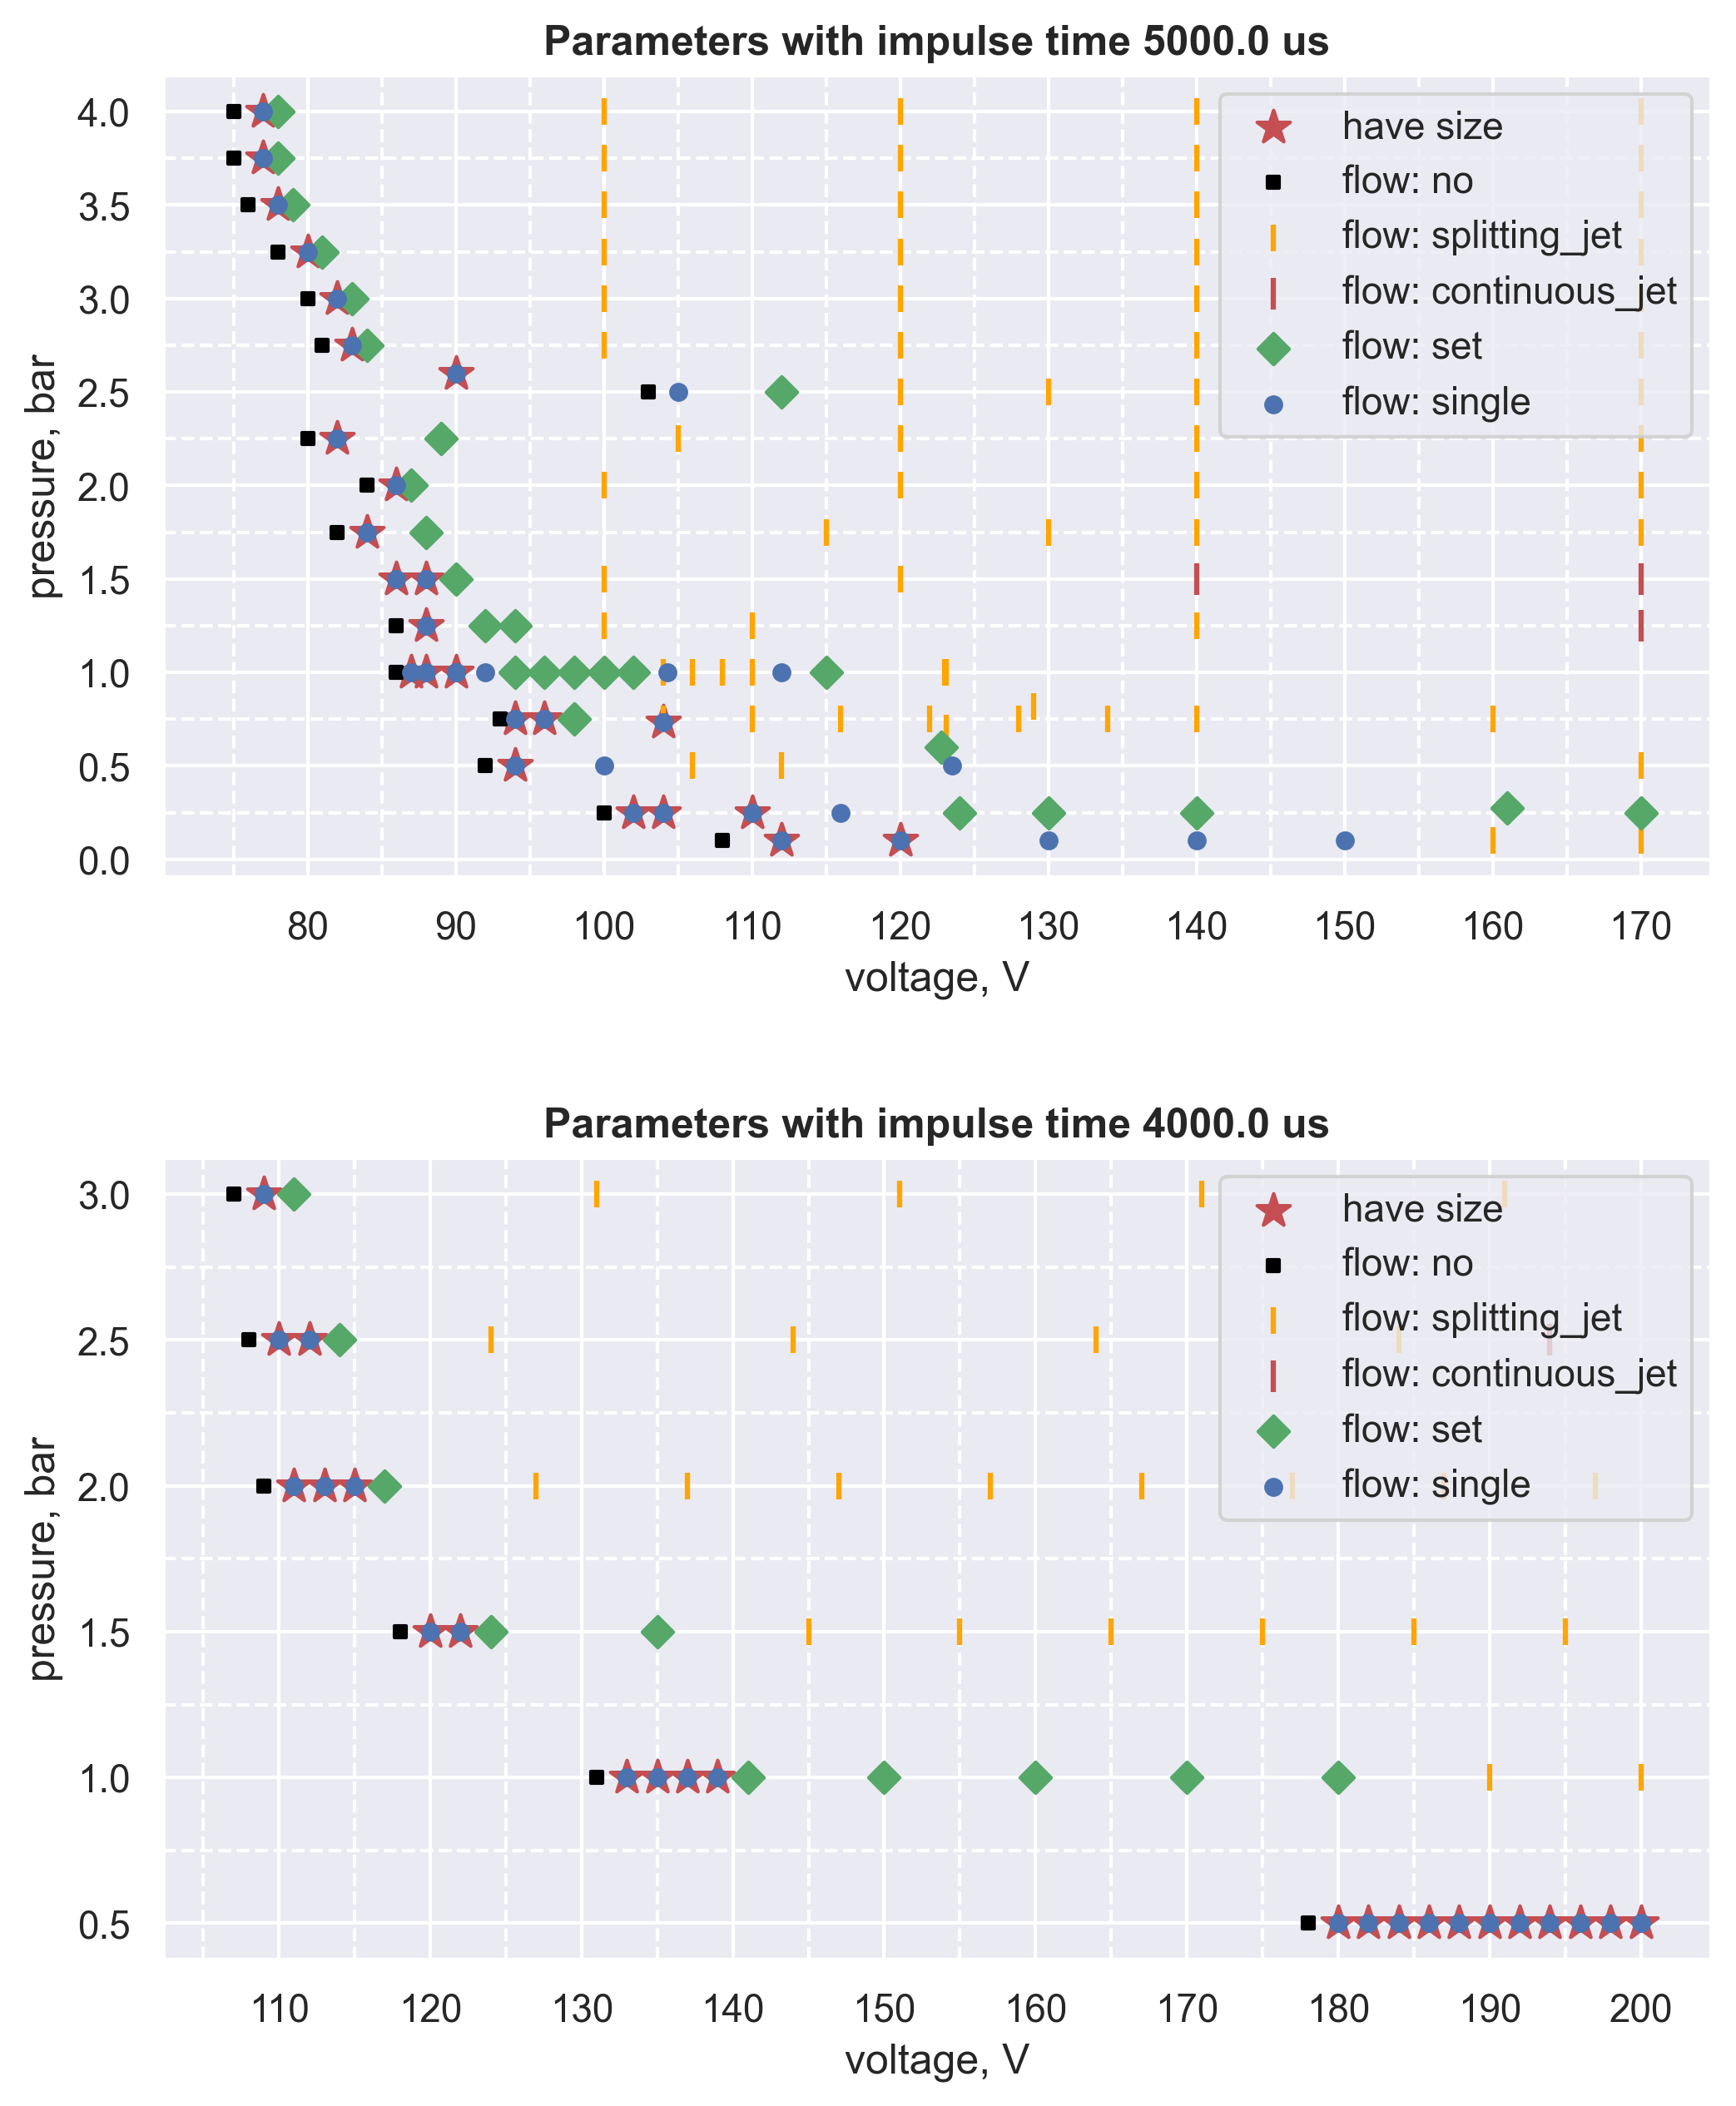

In [12]:
# ОЧИЩЕННЫЕ ПАРАМЕТРИЧЕСКИЕ КАРТЫ
one_needle_df = prot_df[prot_df['needle']=='N01-1']
# Разделим данные по времени импульса
impulse_time_list = list(one_needle_df['impulse_time'].value_counts().index)

# ПОСТРОИМ ГРАФИКИ ПАРАМЕТРОВ
fig, axes = plt.subplots(len(impulse_time_list), 1, figsize=(8,10), dpi=300)
plt.subplots_adjust(wspace=0.35, hspace=0.35)
for i, impulse_time in enumerate(impulse_time_list):
    # Записываем датафрейм с одним значением времени импульса
    one_time_df = one_needle_df[one_needle_df['impulse_time']==impulse_time]
    # Подготавливаем поле для построения
    axes[i].set_title('Parameters with impulse time {} us'.format(impulse_time), fontweight="bold")
    axes[i].set_xlabel('voltage, V')
    axes[i].set_ylabel('pressure, bar')

    # Настраиваем число разделений по осям
    axes[i].yaxis.set_major_locator(MultipleLocator(0.5))
    axes[i].yaxis.set_minor_locator(MultipleLocator(0.25))

    axes[i].xaxis.set_major_locator(MultipleLocator(10))
    axes[i].xaxis.set_minor_locator(MultipleLocator(5))

    axes[i].grid(which='minor', linestyle='--')
    
    # Составим словарь: тип потока : [размер, тип маркера, цвет маркера
    default_size = 10
    flow_type_dict = {
        # 'nan' : [3*default_size, 'X','black'],
        'no' : [1*default_size, ',', 'black'],
        'single' : [2*default_size, 'o', 'b'],
        'set' : [4*default_size, 'D', 'g'],
        'splitting_jet' : [6*default_size, '|', 'orange'],
        'continuous_jet' : [8*default_size, '|', 'r']   
    }

    # Отметим точки, которые проанализированы по размеру
    axes[i].scatter(one_time_df[pd.notna(one_time_df['droplet_size'])]['voltage'], one_time_df[pd.notna(one_time_df['droplet_size'])]['pressure']/1000, s=100, marker ='*', c='r', label='have size')
    
    # Строим графики, разделяя по типу потока
    flow_type_list = ['no', 'splitting_jet', 'continuous_jet', 'set', 'single']

    for flow_type in flow_type_list: 
        one_flow_df = one_time_df[one_time_df['flow_type']==flow_type]
        axes[i].scatter(one_flow_df['voltage'], one_flow_df['pressure']/1000, s=flow_type_dict[flow_type][0], marker =flow_type_dict[flow_type][1], c=flow_type_dict[flow_type][2], label='flow: '+flow_type)
    
    axes[i].legend(loc='upper right')

## Выводы по первому протоколу:
**1. Наличие видео.** 
- **10** видеофайлов отсутствуют вообще. Из них: 
    - **6** тестов без капель; 
    - **1** тест - полный дубликат;
    - **1** тест с неизвестным типом потока. Судя по графику относится к **"splitting_jet"**;
    - **2** теста с другими иглами (**N03-1** - "set" и **N04-1** - неизвестный тип потока). 
- **37** видеофайлов только в формате **avi**. Согласно параметрическим картам соответствующие тесты не представляют интерес с точки зрения необходимости определять размер капли.
- **1** видеофайл в формате **mraw**. Из него возможно получить .avi-файл.
- **194** теста содержат видео **avi** и **mraw**.

**Необходимости в отсустсвующих видеофайлах нет.**

**2. Тип потока из сопла.**
- Дополнительно, в соответствии с видеофайлами, заполнены **25** тестов. Осталось **3** теста с неизвестным типом потока **"nan"**, один из которых является описанным выше дубликатом, а второй - относится к игле **"N04-1"**
- Для дальнейшего анализа интерес прежде всего представляют одиночные капли **"single"**. Имеется **72** теста, **49** из которых обработаны по размеру капли. ***2** теста были проанализированы только по avi??? (См. выше)*

**Уточнять тип потока в 'nan'-тестах нет необходимости.**

**3. Тип иглы.** 
- Наиболее часто использовалась игла **"N01-1"**. Построение параметрических карт ведётся по ней.
- Остальные иглы имеют не более **10** тестов:
    - **"N02-1"** - **10** тестов. Характерно наличие сильных колебаний.
    - **"N03-1"** - **3** теста.
    - **"N04-1"** - **7** тестов. Зачастую не удавалось получить одну каплю.
    - **"N05-1"** - **1** тест.

**Построение параметрических карт будет вестись по игле "N01-1".**

**4. Длительность импульса.**
- Рассматривались импульсы, мкс:
    1. **5000** - **149** тестов. 
    2. **4000** - **64** теста. Требуется бОльшее напряжение для образования капли, чем при 5000 мкс при одном и том же давлении.

**Необходимо провести большее количество тестов при импульсах в 4000 мкс (с шагом 0.25 бар), а также при 5000 мкс в зоне с одной каплей.**

**5. Вылеты тестов.**
- При времени импульса в **5000 мкс** имеются вылеты тестов за области ожидаемых типов потока при давлениях **2.5, 1.0, 0.75, 0.5 бар**.
- Более подробное рассмотрение тестов при этих давлениях показало, что эти вылеты могли возникнуть из-за **наличия пузырей в жидкости** (согласно комментариям к близким тестам той же даты).
- Часть этих вылетов исправлена, так как **был указан неверный тип потока**.

**Необходимо повторить эксперимент для соответствующих давлений в диапазонах напряжений с сомнительным результатом.**

In [13]:
# Сортируем датафрейм по номеру теста
prot_df = prot_df.sort_values('test').reset_index().drop('index', axis=1)
# Сохраняем итоговый dataframe в формате .csv
file_path = os.path.join(main_path, 'GENERATING_DATA.csv')
if os.path.exists(file_path):
    win32api.SetFileAttributes(file_path, win32con.FILE_ATTRIBUTE_NORMAL)

prot_df.to_csv(file_path)

# Сохраним данные в формате .xlsx
file_path = os.path.join(main_path, 'GENERATING_DATA.xlsx')
if os.path.exists(file_path):
    win32api.SetFileAttributes(file_path, win32con.FILE_ATTRIBUTE_NORMAL)

writer = pd.ExcelWriter(file_path, engine='xlsxwriter', datetime_format='YYYY-MM-DD')

excel_columns = ['Test №', 'Test type', 'Voltage, V', 'Pressure, mbar', 'Impulse time, us', 'Needle', 'Nozzle', 'Distance, mm', 'Calibrat test №', 'Record rate, fps', 'Comments', 'Experiment date', 'Tester', 'Video format', 'Pixel size, um', 'Flow type', 'Droplet size, um', 'Starting velocity, m/s', 'Ending velocity, m/s']

prot_df.to_excel(writer, index=False, sheet_name='Main_Data', startrow=1, header=False)
# Форматирование таблицы
workbook = writer.book
worksheet = writer.sheets['Main_Data']
# объекты форматирования
head_fmt = workbook.add_format({'bold': True, 'text_wrap': True, 'align': 'center_across', 'valign': 'center'})
test_num_fmt = workbook.add_format({'bold': True})
test_num_fmt.set_num_format('0000')

calib_num_fmt = workbook.add_format({'bold': False})
calib_num_fmt.set_num_format('0000')

# Сохраняем заголовок
for i, column_name in enumerate(excel_columns):
    worksheet.write(0, i, column_name, head_fmt)

worksheet.set_column('A:A', 5.1, test_num_fmt)
worksheet.set_column('B:B', 8.1)
worksheet.set_column('C:C', 7.1)
worksheet.set_column('D:D', 8.1)
worksheet.set_column('E:E', 7.1)
worksheet.set_column('F:G', 6.1)
worksheet.set_column('I:I', 7.0, calib_num_fmt)
worksheet.set_column('J:J', 7.0)
worksheet.set_column('K:K', 10)
worksheet.set_column('L:L', 10.1)
worksheet.set_column('O:O', 5.1)
worksheet.set_column('P:P', 9.5)
worksheet.set_column('Q:Q', 6.6)
worksheet.set_column('R:S', 7.1)

writer.save()

In [14]:
# Предотвратим возможность редактирования файлов

file_path = os.path.join(main_path, 'GENERATING_DATA.xlsx')
win32api.SetFileAttributes(file_path, win32con.FILE_ATTRIBUTE_READONLY)

file_path = os.path.join(main_path, 'GENERATING_DATA.csv')
win32api.SetFileAttributes(file_path, win32con.FILE_ATTRIBUTE_READONLY)